# 📑 Evaluación de PubMedCLIP en ROCO

Este notebook forma parte del proyecto de tesis sobre **medición del balance multimodal en modelos CLIP aplicados a dominios médicos**.

Modelo actual: **PubMedCLIP**  
Dataset: **ROCO (Radiology Objects in COntext)**  
Tarea: **ISA (Image-Sentence Alignment)**
---


## Clonar repositorio

In [4]:
# 📌 Código
REPO_URL  = "https://github.com/Alberto-97sc/mmshap_medclip.git"
LOCAL_DIR = "/content/mmshap_medclip"
BRANCH    = "main"

%cd /content
import os, shutil, subprocess, sys

if not os.path.isdir(f"{LOCAL_DIR}/.git"):
    # No está clonado aún
    !git clone $REPO_URL $LOCAL_DIR
else:
    # Ya existe: actualiza a la última versión del remoto
    %cd $LOCAL_DIR
    !git fetch origin
    !git checkout $BRANCH
    !git reset --hard origin/$BRANCH
%cd $LOCAL_DIR
!git rev-parse --short HEAD

/content
/content/mmshap_medclip
Already on 'main'
Your branch is up to date with 'origin/main'.
HEAD is now at 75deb88 Eliminación de comentarios innecesarios en el notebook 01_pubmedclip_roco_isa_formateado.ipynb para mejorar la claridad del código.
/content/mmshap_medclip
75deb88


## Instalar dependencias y montar google drive

In [1]:
from google.colab import drive; drive.mount('/content/drive')

# === Instalar en modo editable (pyproject.toml) ===
%pip install -e /content/mmshap_medclip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Obtaining file:///content/mmshap_medclip
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mmshap_medclip (pyproject.toml) ... done
  Created wheel for mmshap_medclip: filename=mmshap_medclip-0.1.0-0.editable-py3-none-any.whl size=3906 sha256=b51cbe016fee457b0e965d60ae38371e781486b23a6c50c4dfd1ca2075c4d61e
  Stored in directory: /tmp/pip-ephem-wheel-cache-bgv6w6nx/wheels/b3/1d/7e/d38403be6961da2a3fb9229d1eb25770838e383069b89a1567
Successfully built mmshap_medclip
  Attempting uninstall: mmshap_medclip
    Found existing installation: mmshap_medclip 0.1.0
    Uninstalling mmshap_medclip-0.1.0:
      Successfully uninstalled mmshap_medclip-0.1.0


In [ ]:
# 📌 Código
from google.colab import drive; drive.mount('/content/drive')

## Cargar modelos y datos

In [5]:
# 📌 Código
CFG_PATH="/content/mmshap_medclip/configs/roco_isa_pubmedclip.yaml"

# Asegura que cfg, device, dataset y model estén listos en esta sesión
if not all(k in globals() for k in ("cfg", "device", "dataset", "model")):
    from mmshap_medclip.io_utils import load_config
    from mmshap_medclip.devices import get_device
    from mmshap_medclip.registry import build_dataset, build_model

    cfg = load_config(CFG_PATH)
    device  = get_device()
    dataset = build_dataset(cfg["dataset"])
    model   = build_model(cfg["model"], device=device)

print("OK → len(dataset) =", len(dataset), "| device =", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

OK → len(dataset) = 8180 | device = cuda


## Ejecutar SHAP en una muestra

logit=32.7188  TScore=61.52%  IScore=38.48%


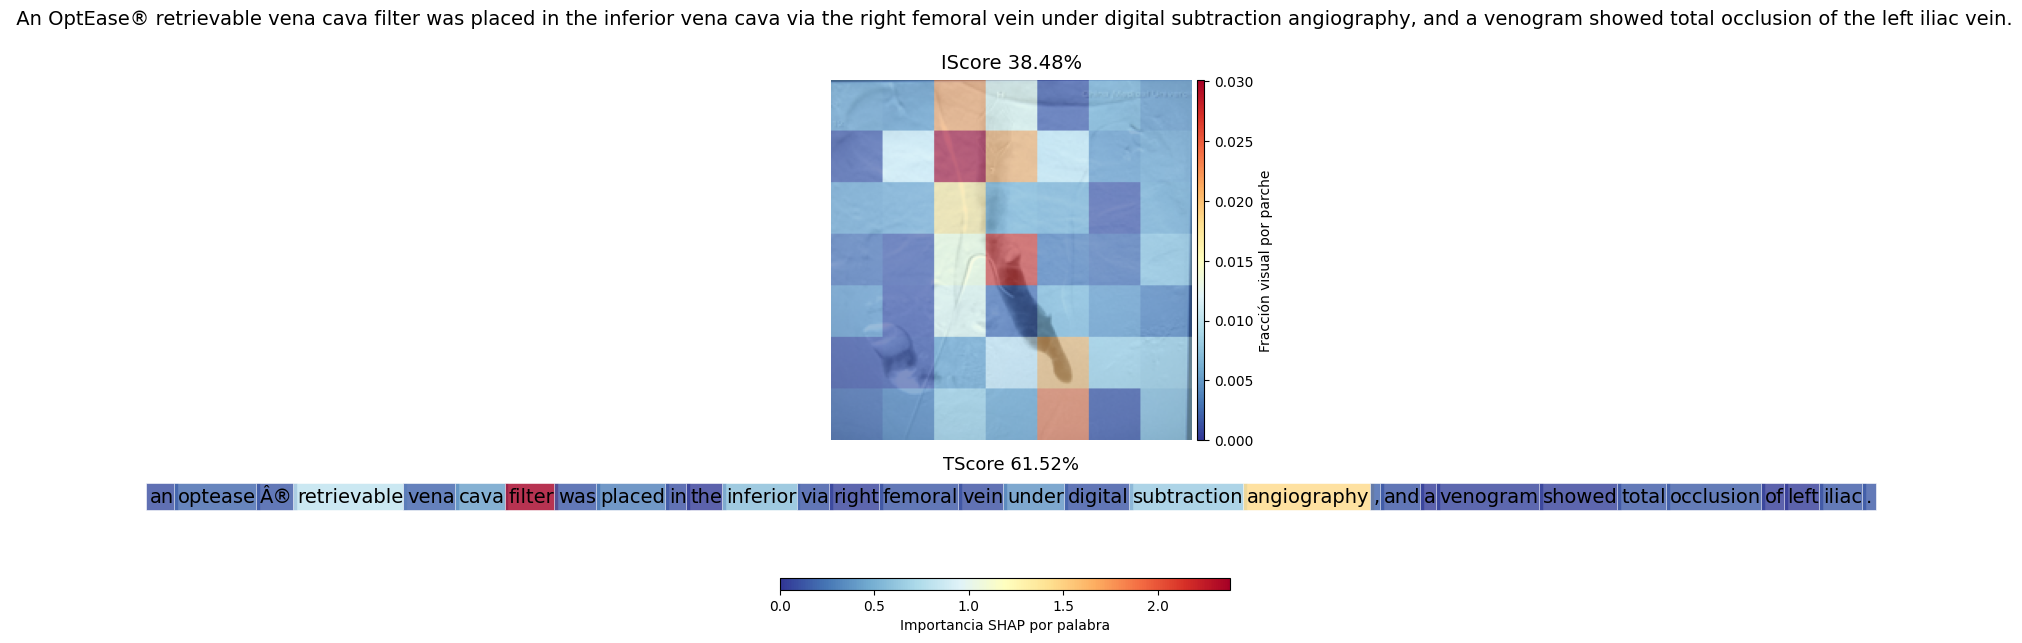

In [6]:
# 📌 Código
from mmshap_medclip.tasks.isa import run_isa_one

muestra = 154
sample  = dataset[muestra]
image, caption = sample['image'], sample['text']

res = run_isa_one(model, image, caption, device, explain=True, plot=True)
print(f"logit={res['logit']:.4f}  TScore={res['tscore']:.2%}  IScore={res['iscore']:.2%}")



Imagen seleccionada: all_data/train/radiology/images/PMC2918840_cro0003-0035-f01.jpg
Caption limpio: Chest X-ray posterior-anterior view showing homogeneous opacity in the left upper lung field with an elevation of the diaphragm on the left side.


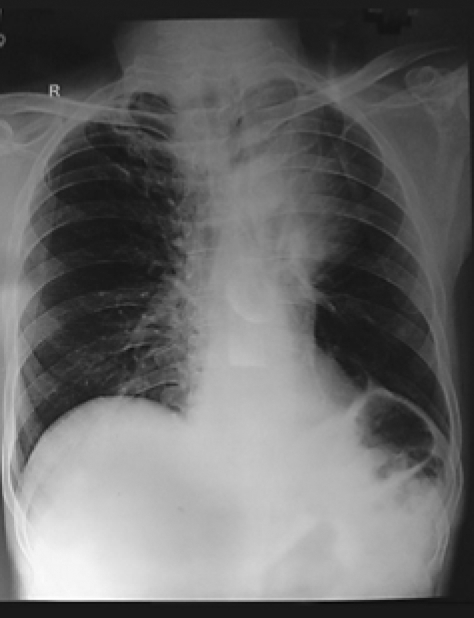


Probabilidades ordenadas:
 0.6342 | pneumothorax
 0.2405 | atelectasis
 0.0619 | pleural effusion
 0.0255 | Chest X-ray posterior-anterior view showing homogeneous opacity in the left upper lung field with an elevation of the diaphragm on the left side.
 0.0213 | cardiomegaly
 0.0157 | consolidation
 0.0008 | normal chest X-ray


In [7]:
# ==== Config ====
zip_path = "/content/drive/MyDrive/MAESTRIA-TESIS/datasets/ROCO/dataset_roco.zip"

# ==== Funciones auxiliares ====
import zipfile, io, re, random
import pandas as pd
from pathlib import Path
from PIL import Image
from io import BytesIO

def clean_roco_caption(text):
    t = re.sub(r"^\s*ROCO_\d+\s*[\t,|;]\s*", "", str(text)).strip()
    t = re.sub(r"\s+", " ", t)
    return t

def load_radiology_df_from_zip(zf, split="train"):
    # busca CSV dentro de radiology del split
    candidates = [n for n in zf.namelist() if n.startswith(f"all_data/{split}/radiology/") and n.lower().endswith(".csv")]
    if not candidates:
        raise RuntimeError("No encontré CSVs de radiology en el split.")
    raw = zf.read(candidates[0])
    for enc in ("utf-8","utf-8-sig","latin-1"):
        try:
            df = pd.read_csv(io.BytesIO(raw), encoding=enc)
            break
        except Exception:
            df = None
    if df is None or df.empty:
        raise RuntimeError("No pude leer el CSV.")
    cols = {c.lower(): c for c in df.columns}
    return df, cols.get("name"), cols.get("caption")

def pick_chestxray_sample(zf, split="train"):
    df, name_col, cap_col = load_radiology_df_from_zip(zf, split)
    # filtrar por captions que contengan 'chest x-ray' o 'lung'
    mask = df[cap_col].astype(str).str.lower().str.contains("chest x-ray|lung")
    filtered = df[mask]
    if filtered.empty:
        raise RuntimeError("No encontré captions con 'chest x-ray' o 'lung'.")
    row = filtered.sample(1).iloc[0]
    img_name = str(row[name_col])
    cap = clean_roco_caption(row[cap_col])
    img_rel = f"all_data/{split}/radiology/images/{Path(img_name).name}"
    if img_rel not in zf.namelist():
        # fallback si CSV trae ruta completa
        cand = f"all_data/{split}/radiology/{img_name}"
        if cand in zf.namelist():
            img_rel = cand
        else:
            matches = [n for n in zf.namelist() if n.endswith(Path(img_name).name)]
            if matches:
                img_rel = matches[0]
    return img_rel, cap

# ==== Seleccionar imagen y caption ====
with zipfile.ZipFile(zip_path, "r") as z:
    image_rel, caption_clean = pick_chestxray_sample(z, split="train")
    img = Image.open(BytesIO(z.read(image_rel))).convert("RGB")

print("Imagen seleccionada:", image_rel)
print("Caption limpio:", caption_clean)
display(img)

# ==== WhyXrayCLIP ====
!pip install -q open_clip_torch pillow torch torchvision --upgrade
import torch, open_clip

model, _, preprocess = open_clip.create_model_and_transforms("hf-hub:yyupenn/whyxrayclip")
tokenizer = open_clip.get_tokenizer("ViT-L-14")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

image_tensor = preprocess(img).unsqueeze(0).to(device)

labels = [
    caption_clean,
    "normal chest X-ray",
    "cardiomegaly",
    "pleural effusion",
    "pneumothorax",
    "consolidation",
    "atelectasis",
]
text = tokenizer(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features  = model.encode_text(text)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)
    probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).squeeze(0).cpu().numpy()

print("\nProbabilidades ordenadas:")
for lbl, p in sorted(zip(labels, probs), key=lambda x: x[1], reverse=True):
    print(f"{p:7.4f} | {lbl}")
